# 공유 자전거 수요 예측 (11.24 정호섭)

### 목표
- 전처리 최적화
- `하나쌤 완벽하게 이해시키기`
- `기본 베이스라인 만들기`
- `지금까지 전처리한 변수를 통해 비교해보기`

### 라이브러리 및 데이터 불러오기

In [1]:
# 기본 라이브러리
import numpy as np
import pandas as pd 

# 시각화 라이브러리
import matplotlib.pyplot as plt 
import seaborn as sns

# 모델링을 위한 sklearn 패키지
from sklearn.model_selection import train_test_split

# 베이스라인은 회귀모델로 짜본 후, tree 모델들을 활용하여 비교해볼게요.
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor

# score를 내줄 함수
from sklearn.metrics import make_scorer

# 모델링에 활용한 패키지
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 데이터 불러오기
train = pd.read_csv('data/train(전처리 이전).csv')
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,hw_14,hw_15,hw_16,hw_17,hw_18,hw_19,hw_20,hw_21,hw_22,hw_23
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,...,0,0,0,0,0,0,0,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,...,0,0,0,0,0,0,0,0,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,...,0,0,0,0,0,0,0,0,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,...,0,0,0,0,0,0,0,0,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
test = pd.read_csv('data/test (전처리 이전).csv')
test.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,...,hw_14,hw_15,hw_16,hw_17,hw_18,hw_19,hw_20,hw_21,hw_22,hw_23
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,2012,...,0,0,0,0,0,1,0,0,0,0
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,2012,...,0,0,0,0,0,0,1,0,0,0
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,2012,...,0,0,0,0,0,0,0,1,0,0
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,2012,...,0,0,0,0,0,0,0,0,1,0
6492,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981,2012,...,0,0,0,0,0,0,0,0,0,1


### 베이스라인 모델링

In [44]:
# 전처리한 변수들이 있는데 이 중에서 분석에 활용한 변수를 선택해줍시다.
# 선택된 변수들은 아래와 같습니다.
cols = ['season', 'holiday', 'workingday', 'weather', 'temp', 'humidity', 'windspeed', 'year', 'month', 'hour', 'dayofweek', 'log_count']

# 기존 데이터에 덮어쓰기보단 train_copy라는 예비 데이터프레임을 생성하여 저장해줍시다.
train_copy = train[cols]

# count를 제외한 변수들을 담은 데이터프레임. 여기선 슬라이싱을 활용했습니다. 
# [:-1]이면 마지막 열을 제외하게 됩니다.
X_features = train[cols[:-1]]
X_test = test[cols[:-1]]

# 타겟 변수는 log 처리를 해준 count 변수
target = train['log_count']

# 데이터를 나눠줌
X_train, X_valid, y_train, y_valid = train_test_split(X_features, target, test_size = 0.3, random_state = 0)

In [45]:
# RMSLE 값을 출력하는 함수
def rmsle(y,y_,convertExp=True):
    # 지수화 필요하다면
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

In [46]:
# cross val score를 측정해주는 함수
def cv_score(models):
    for model in models:
        model.fit(X_train,y_train)
        score =  cross_val_score(model, X_train, y_train, cv = kf, scoring=rmsle_scorer)
        print(model[0],'의 평균 score:', round(score.mean(), 5))
        print(model[0],'의 평균 std:', round(score.std(), 5))
        print()      
        
        # y_valid과 prediction을 비교하여 시각화 해주는 코드
        g = sns.kdeplot(np.exp(y_valid),  color = 'skyblue', alpha = .6, fill = True, label = 'valid')
        g = sns.kdeplot(np.exp(model.predict(X_valid)), color = 'orange', alpha = .3, fill = True, label = 'prediction')
        plt.legend()
        plt.show()

In [47]:
 # 제출을 위한 함수
def submission(model):
    model.fit(X_train, y_train)
    prediction = np.exp(model.predict(X_test))
    
    # 자동으로 형식을 맞춰 csv 생성해주는 코드
    submission = pd.DataFrame(test['datetime'])
    submission['count'] = prediction
    pd.DataFrame(submission).to_csv('submission.csv', index = False)
    
    return pd.DataFrame(submission)

LinearRegression() 의 평균 score: 0.98054
LinearRegression() 의 평균 std: 0.00418



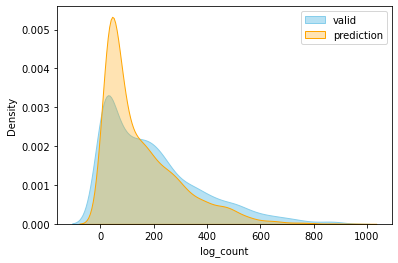

RandomForestRegressor() 의 평균 score: 0.29347
RandomForestRegressor() 의 평균 std: 0.01085



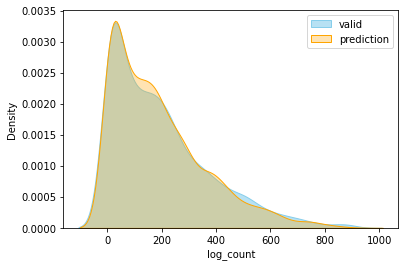

LGBMRegressor() 의 평균 score: 0.27209
LGBMRegressor() 의 평균 std: 0.01023



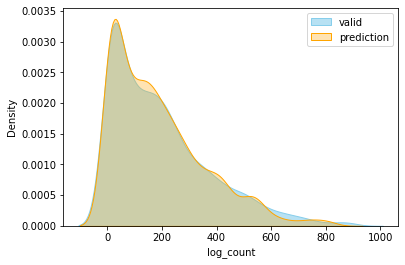

In [48]:
# 기본 모델을 아래와 같이 3가지로 정했음.
pipe_lr = Pipeline([('model', LinearRegression())])
pipe_rf = Pipeline([('model', RandomForestRegressor(n_estimators=100))])
pipe_lgbm = Pipeline([('model', LGBMRegressor(n_estimators=100))])
models = [pipe_lr, pipe_rf, pipe_lgbm]

# kfold 수는 default인 5로 지정
kf = KFold(n_splits=5, shuffle=True)

# 평균 score 측정
cv_score(models)

평균 cross val score의 점수와 표준편차가 가장 낮은 LightGBM 모델을 사용한다.

In [9]:
# lgbm 모델 제출 결과 0.4179
# rf 모델 제출 결과 : 0.4498
submission(pipe_rf)

,datetime,count
0,2011-01-20 00:00:00,13.521080
1,2011-01-20 01:00:00,6.749063
2,2011-01-20 02:00:00,4.929002
3,2011-01-20 03:00:00,4.412391
4,2011-01-20 04:00:00,3.652749
...,...,...
6488,2012-12-31 19:00:00,287.126218
6489,2012-12-31 20:00:00,202.287081
6490,2012-12-31 21:00:00,149.154097
6491,2012-12-31 22:00:00,111.661078


### 모델링
기본 베이스라인을 기준으로, 다양한 처리기법을 통해 모델의 성능을 비교 및 향상시키는 것이 목적이다.

In [10]:
train = pd.read_csv('data/train(전처리 완료).csv')
test = pd.read_csv('data/test (전처리 완료).csv')

In [11]:
# 전처리한 변수들이 있는데 이 중에서 분석에 활용한 변수를 선택해줍시다.
# 선택된 변수들은 아래와 같습니다.
cols = ['year','rainyday', 'temp_scaled', 'h_0',
              'h_1', 'h_2', 'h_3', 'h_4', 'h_5', 'h_6', 'h_7', 'h_8', 'h_9', 'h_10',
              'h_11', 'h_12', 'h_13', 'h_14', 'h_15', 'h_16', 'h_17', 'h_18', 'h_19',
              'h_20', 'h_21', 'h_22', 'h_23','hw_0', 'hw_1', 'hw_2', 'hw_3', 'hw_4', 'hw_5',
              'hw_6', 'hw_7', 'hw_8', 'hw_9', 'hw_10', 'hw_11', 'hw_12', 'hw_13',
              'hw_14', 'hw_15', 'hw_16', 'hw_17', 'hw_18', 'hw_19', 'hw_20', 'hw_21',
              'hw_22', 'hw_23', 'count']

# 기존 데이터에 덮어쓰기보단 train_copy라는 예비 데이터프레임을 생성하여 저장해줍시다.
train_copy = train[cols]

# count를 제외한 변수들을 담은 데이터프레임. 여기선 슬라이싱을 활용했습니다. 
# [:-1]이면 마지막 열을 제외하게 됩니다.
X_features = train[cols[:-1]]
X_test = test[cols[:-1]]

# 타겟 변수는 log 처리를 해준 count 변수
target = train['log_count']

# 데이터를 나눠줌
X_train, X_valid, y_train, y_valid = train_test_split(X_features, target, test_size = 0.3, random_state = 0)

LinearRegression() 의 평균 score: 0.39526
LinearRegression() 의 평균 std: 0.01153



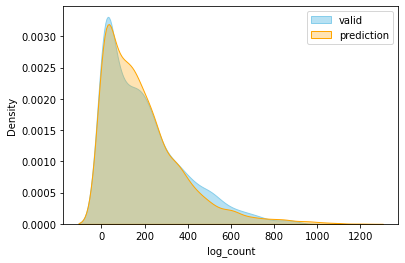

RandomForestRegressor() 의 평균 score: 0.42532
RandomForestRegressor() 의 평균 std: 0.00486



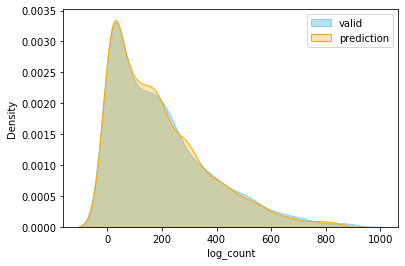

LGBMRegressor() 의 평균 score: 0.37585
LGBMRegressor() 의 평균 std: 0.0052



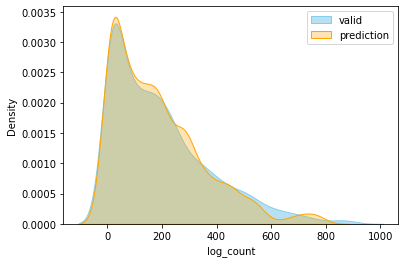

In [12]:
# 평균 score 측정
cv_score(models)

교호 작용을 적용하여 선형 회귀 모델의 성능은 좋아졌지만 tree 기반 모델의 성능은 크게 나아지지 않았다.

In [40]:
train = pd.read_csv('data/train(전처리 이전).csv')
test = pd.read_csv('data/test (전처리 이전).csv')

In [41]:
# 전처리한 변수들이 있는데 이 중에서 분석에 활용한 변수를 선택해줍시다.
# 선택된 변수들은 아래와 같습니다.
cols = ['season', 'holiday', 'workingday', 'weather', 'humidity', 'windspeed', 'month', 'dayofweek', 'year','rainyday', 'temp_scaled', 'hour', 'log_count']

# 기존 데이터에 덮어쓰기보단 train_copy라는 예비 데이터프레임을 생성하여 저장해줍시다.
train_copy = train[cols]

# count를 제외한 변수들을 담은 데이터프레임. 여기선 슬라이싱을 활용했습니다. 
# [:-1]이면 마지막 열을 제외하게 됩니다.
X_features = train[cols[:-1]]
X_test = test[cols[:-1]]

In [42]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_col = ['season', 'holiday', 'workingday', 'weather', 'year', 'month', 'hour']

for col in categorical_col:
    X_features[col] = X_features[col].astype('object')

X_features = pd.get_dummies(X_features)

# 타겟 변수는 log 처리를 해준 count 변수
target = train['log_count']

# 데이터를 나눠줌
X_train, X_valid, y_train, y_valid = train_test_split(X_features, target, test_size = 0.3, random_state = 0)

LinearRegression() 의 평균 score: 0.55679
LinearRegression() 의 평균 std: 0.0178



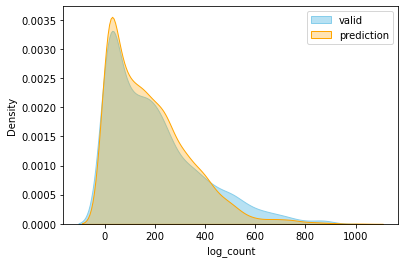

RandomForestRegressor() 의 평균 score: 0.31825
RandomForestRegressor() 의 평균 std: 0.00876



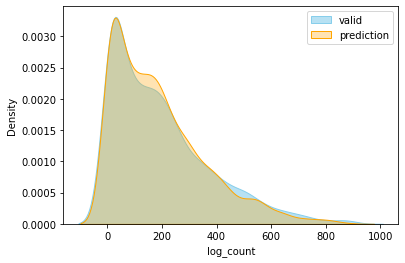

LGBMRegressor() 의 평균 score: 0.29918
LGBMRegressor() 의 평균 std: 0.00486



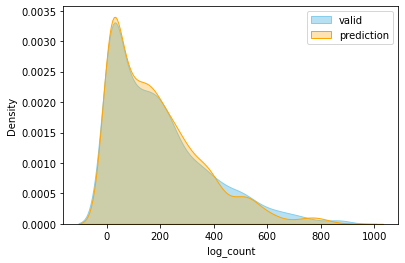

In [43]:
# 평균 score 측정
cv_score(models)